In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
torch.manual_seed(4)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [12]:
dataset = datasets.OxfordIIITPet(root='./data', target_types='segmentation', target_transform=transform, download=True, transform=transform)
train_set, test_set = torch.utils.data.random_split(dataset, [3500, len(dataset)-3500])
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

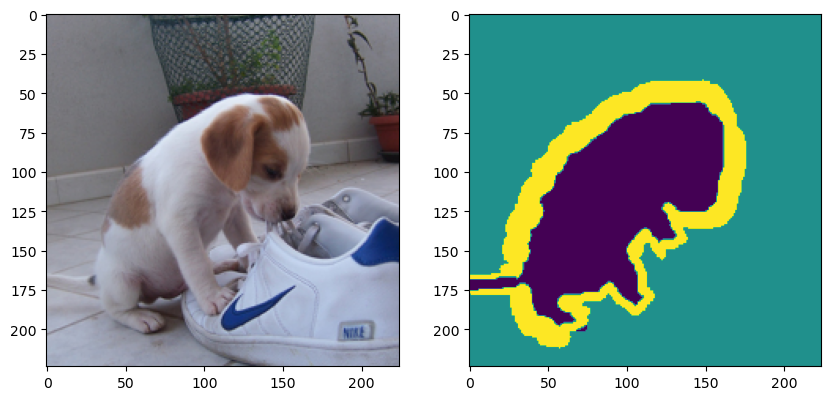

In [3]:
a, b = next(iter(train_loader))

# print(a.shape)
# print(b.shape)

# print(a[0])
# print(b[0])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
data_index = 10
ax[0].imshow(a[data_index].permute(1, 2, 0))
ax[1].imshow(b[data_index, 0])

### Define the UNet class

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]
            cbr = nn.Sequential(*layers)

            return cbr

        self.enc1_1 = CBR(in_channels=3, out_channels=64)
        self.enc1_2 = CBR(in_channels=64, out_channels=64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR(in_channels=64, out_channels=128)
        self.enc2_2 = CBR(in_channels=128, out_channels=128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR(in_channels=128, out_channels=256)
        self.enc3_2 = CBR(in_channels=256, out_channels=256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR(in_channels=256, out_channels=512)
        self.enc4_2 = CBR(in_channels=512, out_channels=512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR(in_channels=512, out_channels=1024)
        self.enc5_2 = CBR(in_channels=1024, out_channels=1024)

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_1 = CBR(in_channels=1024, out_channels=512)
        self.dec1_2 = CBR(in_channels=512, out_channels=512)

        self.upconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_1 = CBR(in_channels=512, out_channels=256)
        self.dec2_2 = CBR(in_channels=256, out_channels=256)

        self.upconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_1 = CBR(in_channels=256, out_channels=128)
        self.dec3_2 = CBR(in_channels=128, out_channels=128)

        self.upconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_1 = CBR(in_channels=128, out_channels=64)
        self.dec4_2 = CBR(in_channels=64, out_channels=64)

        self.outconv = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool2(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        enc5_2 = self.enc5_2(enc5_1)

        upconv1 = self.upconv1(enc5_2)
        cat1 = torch.cat((upconv1, enc4_2), dim=1)

        dec1_1 = self.dec1_1(cat1)
        dec1_2 = self.dec1_2(dec1_1)

        upconv2 = self.upconv2(dec1_2)
        cat2 = torch.cat((upconv2, enc3_2), dim=1)

        dec2_1 = self.dec2_1(cat2)
        dec2_2 = self.dec2_2(dec2_1)

        upconv3 = self.upconv3(dec2_2)
        cat3 = torch.cat((upconv3, enc2_2), dim=1)

        dec3_1 = self.dec3_1(cat3)
        dec3_2 = self.dec3_2(dec3_1)

        upconv4 = self.upconv4(dec3_2)
        cat4 = torch.cat((upconv4, enc1_2), dim=1)

        dec4_1 = self.dec4_1(cat4)
        dec4_2 = self.dec4_2(dec4_1)

        outconv = self.outconv(dec4_2)

        return outconv

In [5]:
model30 = UNet()
model30.load_state_dict(torch.load('./model_state_dicts/unet_miou30.pth', map_location=torch.device('cpu')))

model50 = UNet()
model50.load_state_dict(torch.load('./model_state_dicts/unet_miou50.pth', map_location=torch.device('cpu')))

model70 = UNet()
model70.load_state_dict(torch.load('./model_state_dicts/unet_miou70.pth', map_location=torch.device('cpu')))

model90 = UNet()
model90.load_state_dict(torch.load('./model_state_dicts/unet_miou90.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [6]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

In [13]:
print(model90)

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### Add hooks to conv layers

In [7]:
class GradCam(nn.Module):
    def __init__(self, model, module, layer):
        super().__init__()
        self.model = model
        self.module = module
        self.layer = layer
        self.register_hooks()

    def register_hooks(self):
        for module_name, module in self.model._modules.items():
            if module_name == self.module:
                for layer_name, module in module._modules.items():
                    if layer_name == self.layer:
                        module.register_forward_hook(self.forward_hook)
                        module.register_backward_hook(self.backward_hook)

    def forward(self, input, target_index):
        outs = self.model(input)
        outs = outs.squeeze()

        if target_index is None:
            target_index = torch.argmax(outs, dim=0)

        if target_index == 0:
            outs[0, 112, 112].backward(retain_graph=True)
        elif target_index == 1:
            outs[1, 0, 0].backward(retain_graph=True)
        else:
            outs[2, 0, 25].backward(retain_graph=True)

        a_k = torch.mean(self.backward_result, dim=(1, 2), keepdim=True)
        out = torch.sum(a_k * self.forward_result, dim=0).cpu()
        out = torch.relu(out) / torch.max(out)
        out = F.upsample_bilinear(out.unsqueeze(0).unsqueeze(0), [224, 224])
        return out.cpu().detach().squeeze().numpy()

    def forward_hook(self, _, input, output):
        self.forward_result = torch.squeeze(output)

    def backward_hook(self, _, grad_input, grad_output):
        self.backward_result = torch.squeeze(grad_output[0])

### Plot Grad-CAM

Text(0.5, 1.0, 'Target')

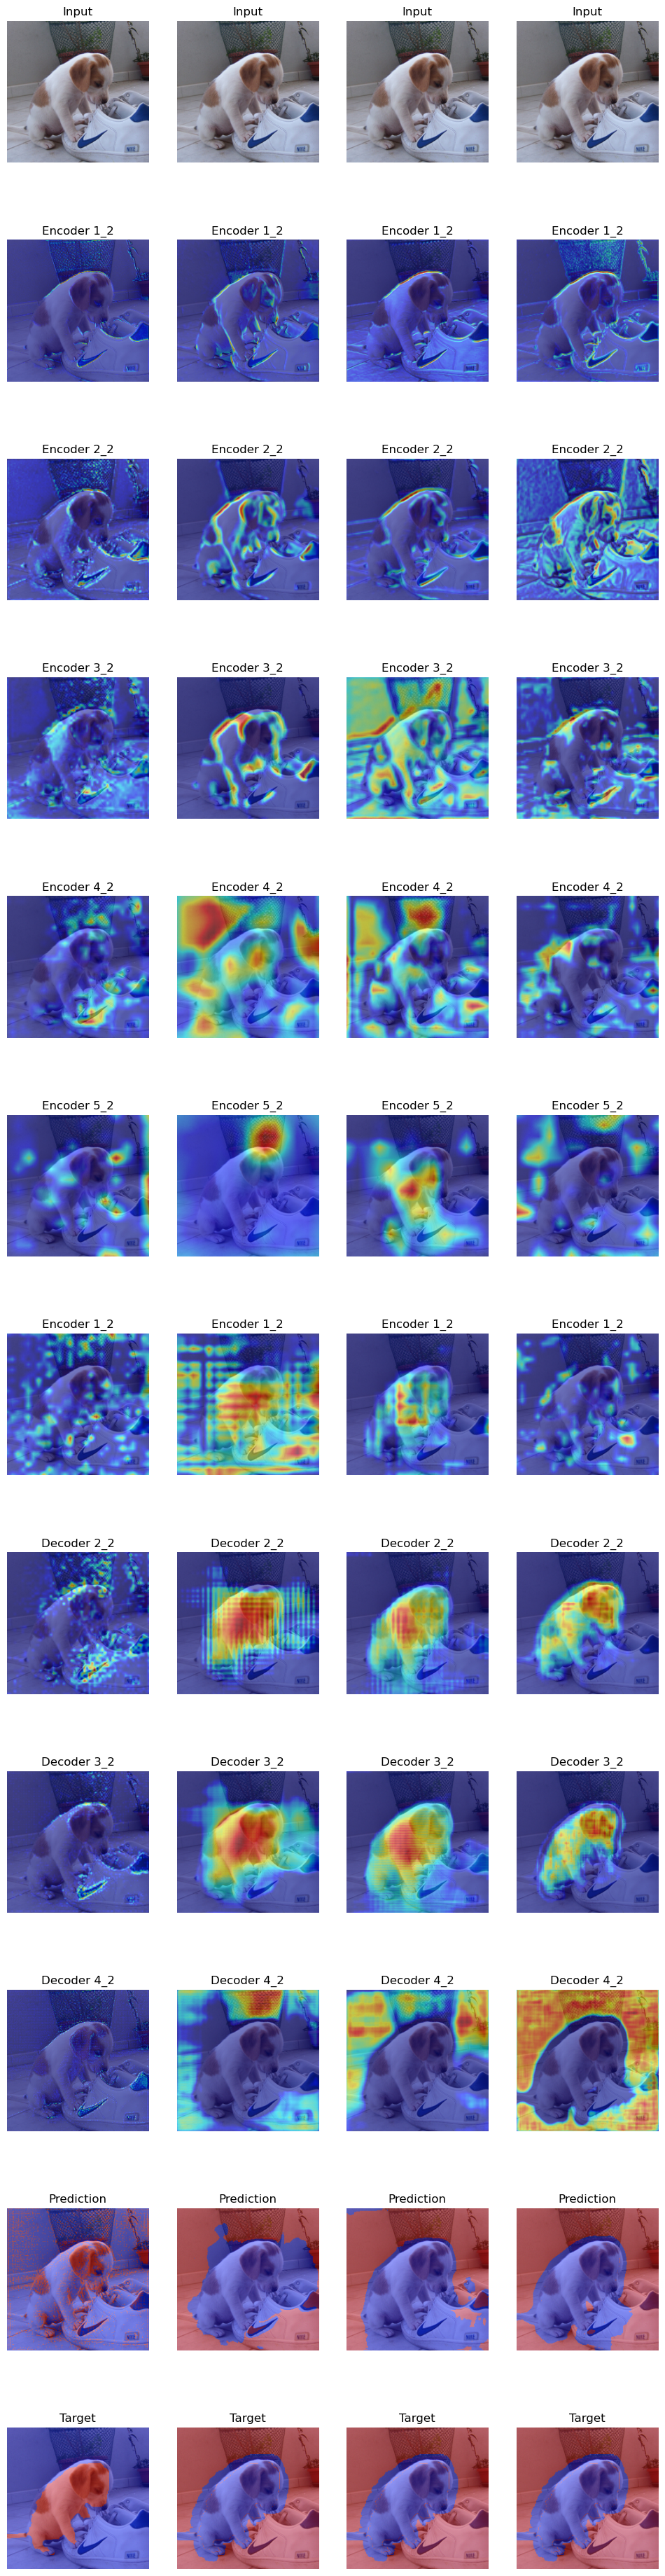

In [9]:
fig, ax = plt.subplots(12, 4, figsize=(12, 48))
img = a[data_index].permute(1, 2, 0).detach().cpu().numpy()
img = preprocess_image(img)

module_list = ['enc1_2', 'enc2_2', 'enc3_2', 'enc4_2', 'enc5_2', 'dec1_2', 'dec2_2', 'dec3_2', 'dec4_2']

ax[0, 0].imshow(a[data_index].permute(1, 2, 0))
ax[0, 0].axis('off')
ax[0, 0].set_title('Input')

for i, module in enumerate(module_list):
    grad_cam = GradCam(model=model30, module=module, layer='2')
    mask = grad_cam(img, 0)
    heatmap = cv2.applyColorMap(np.uint8(mask * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
    cam = cam / np.max(cam)
    ax[i+1, 0].imshow(cam)
    ax[i+1, 0].axis('off')
    if i <= 5:
        ax[i+1, 0].set_title('Encoder '+module[3:])
    else:
        ax[i+1, 0].set_title('Decoder '+module[3:])


output = model30(a[data_index].unsqueeze(0))
seg_map = output.argmax(dim=1) == 0
heatmap = cv2.applyColorMap(np.uint8(seg_map.squeeze() * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
ax[10, 0].imshow(cam)
ax[10, 0].axis('off')
ax[10, 0].set_title('Prediction')

unique_values, y_class = torch.unique(b, return_inverse=True)
y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32)
heatmap = cv2.applyColorMap(np.uint8(y_onehot[data_index, 0] * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
plt.imshow(cam)
ax[11, 0].imshow(cam)
ax[11, 0].axis('off')
ax[11, 0].set_title('Target')

ax[0, 1].imshow(a[data_index].permute(1, 2, 0))
ax[0, 1].axis('off')
ax[0, 1].set_title('Input')

for i, module in enumerate(module_list):
    grad_cam = GradCam(model=model50, module=module, layer='2')
    mask = grad_cam(img, 1)
    heatmap = cv2.applyColorMap(np.uint8(mask * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
    cam = cam / np.max(cam)
    ax[i+1, 1].imshow(cam)
    ax[i+1, 1].axis('off')
    if i <= 5:
        ax[i+1, 1].set_title('Encoder '+module[3:])
    else:
        ax[i+1, 1].set_title('Decoder '+module[3:])

output = model50(a[data_index].unsqueeze(0))
seg_map = output.argmax(dim=1) == 1
heatmap = cv2.applyColorMap(np.uint8(seg_map.squeeze() * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
ax[10, 1].imshow(cam)
ax[10, 1].axis('off')
ax[10, 1].set_title('Prediction')

unique_values, y_class = torch.unique(b, return_inverse=True)
y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32)
heatmap = cv2.applyColorMap(np.uint8(y_onehot[data_index, 1] * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
plt.imshow(cam)
ax[11, 1].imshow(cam)
ax[11, 1].axis('off')
ax[11, 1].set_title('Target')


ax[0, 2].imshow(a[data_index].permute(1, 2, 0))
ax[0, 2].axis('off')
ax[0, 2].set_title('Input')

for i, module in enumerate(module_list):
    grad_cam = GradCam(model=model70, module=module, layer='2')
    mask = grad_cam(img, 1)
    heatmap = cv2.applyColorMap(np.uint8(mask * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
    cam = cam / np.max(cam)
    ax[i+1, 2].imshow(cam)
    ax[i+1, 2].axis('off')
    if i <= 5:
        ax[i+1, 2].set_title('Encoder '+module[3:])
    else:
        ax[i+1, 2].set_title('Decoder '+module[3:])

output = model70(a[data_index].unsqueeze(0))
seg_map = output.argmax(dim=1) == 1
heatmap = cv2.applyColorMap(np.uint8(seg_map.squeeze() * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
ax[10, 2].imshow(cam)
ax[10, 2].axis('off')
ax[10, 2].set_title('Prediction')

unique_values, y_class = torch.unique(b, return_inverse=True)
y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32)
heatmap = cv2.applyColorMap(np.uint8(y_onehot[data_index, 1] * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
plt.imshow(cam)
ax[11, 2].imshow(cam)
ax[11, 2].axis('off')
ax[11, 2].set_title('Target')


ax[0, 3].imshow(a[data_index].permute(1, 2, 0))
ax[0, 3].axis('off')
ax[0, 3].set_title('Input')

for i, module in enumerate(module_list):
    grad_cam = GradCam(model=model90, module=module, layer='2')
    mask = grad_cam(img, 1)
    heatmap = cv2.applyColorMap(np.uint8(mask * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
    cam = cam / np.max(cam)
    ax[i+1, 3].imshow(cam)
    ax[i+1, 3].axis('off')
    if i <= 5:
        ax[i+1, 3].set_title('Encoder '+module[3:])
    else:
        ax[i+1, 3].set_title('Decoder '+module[3:])

output = model90(a[data_index].unsqueeze(0))
seg_map = output.argmax(dim=1) == 1
heatmap = cv2.applyColorMap(np.uint8(seg_map.squeeze() * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
ax[10, 3].imshow(cam)
ax[10, 3].axis('off')
ax[10, 3].set_title('Prediction')

unique_values, y_class = torch.unique(b, return_inverse=True)
y_onehot = nn.functional.one_hot(y_class, 3).squeeze(dim=1).permute(0, 3, 1, 2).to(torch.float32)
heatmap = cv2.applyColorMap(np.uint8(y_onehot[data_index, 1] * 255), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
cam = (np.float32(heatmap) / 255) + np.float32(a[data_index].permute(1, 2, 0))
cam = cam / np.max(cam)
plt.imshow(cam)
ax[11, 3].imshow(cam)
ax[11, 3].axis('off')
ax[11, 3].set_title('Target')